# **1. 파일 열기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#1분정도 로드하는데 걸림
import pandas as pd

file_path = '/content/drive/MyDrive/miniproject/data/books.csv'
file_path2 = '/content/drive/MyDrive/miniproject/data/library.csv'
file_path3 = '/content/drive/MyDrive/miniproject/data/library_books.csv'
file_path4 = '/content/drive/MyDrive/miniproject/data/loan_information.csv'

book = pd.read_csv(file_path)  #books
libr = pd.read_csv(file_path2) #library
libo = pd.read_csv(file_path3) #library_books
loan = pd.read_csv(file_path4) #loan_info

<ipython-input-2-d3e7b53d22a7>:9: DtypeWarning: Columns (7,17) have mixed types. Specify dtype option on import or set low_memory=False.
  book = pd.read_csv(file_path)  #books
<ipython-input-2-d3e7b53d22a7>:11: DtypeWarning: Columns (0,2,3,4,8,9,11,12,13,14,15,18,19,20,21,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  libo = pd.read_csv(file_path3) #library_books
<ipython-input-2-d3e7b53d22a7>:12: DtypeWarning: Columns (11,20) have mixed types. Specify dtype option on import or set low_memory=False.
  loan = pd.read_csv(file_path4) #loan_info


In [ ]:
# 각각 결측치와 기초통계가 궁금하당
dfs = {'book': book, 'libr': libr, 'libo': libo, 'loan': loan}

for name, df in dfs.items():
    print(f"\n===== 📘 DataFrame: {name} =====\n")

    print("🔍 결측치 개수:")
    print(df.isnull().sum())

    print("\n📊 기초 통계량:")
    print(df.describe(include='all'))



===== 📘 DataFrame: book =====

🔍 결측치 개수:
SEQ_NO                            0
ISBN_THIRTEEN_NO                  0
VLM_NM                        85194
TITLE_NM                          0
AUTHR_NM                         96
PUBLISHER_NM                   6018
PBLICTE_DE                   102819
ADTION_SMBL_NM                25084
PRC_VALUE                     36008
IMAGE_URL                     43267
BOOK_INTRCN_CN                51685
KDC_NM                        19317
TITLE_SBST_NM                  2689
AUTHR_SBST_NM                  2787
TWO_PBLICTE_DE                41404
INTNT_BOOKST_BOOK_EXST_AT      2767
PORTAL_SITE_BOOK_EXST_AT       2767
ISBN_NO                       53209
dtype: int64

📊 기초 통계량:
              SEQ_NO  ISBN_THIRTEEN_NO VLM_NM            TITLE_NM AUTHR_NM  \
count   1.028190e+05      1.028190e+05  17625              102819   102723   
unique           NaN               NaN    776               87056    71166   
top              NaN               NaN      2  이것이 법

## (이건 실행 안 해도 됨) `ISBN_THIRTEEN_NO` 컬럼을 기준으로 파일 세 개 합치기!

loan(loan_info) + libo(library_books) + book(books) + libr(library)

== data 라는 이름으로 저장

In [ ]:
# ✅ 0. libo에서 필요한 컬럼만 먼저 가져오기
libo_cols_full = [
    'AUTHR_NM', 'PBLICTE_YEAR', 'CL_SMBL_NO', 'BOOK_SMBL_NO', 'TITLE_NM',
    'LBRRY_CD', 'ISBN_THIRTEEN_NO', 'REGIST_NO', 'INCME_FLAG_NM',
    'CL_SMBL_FLAG_NM', 'REGIST_DE', 'SET_ISBN_CHG_AT',
    'KDC_NM', 'BOOK_CL_CD', 'BOOK_LC_CD'
]
libo = libo[libo_cols_full]

# 🔧 1. 데이터 타입 통일 & 결측치 제거 (loan, libo)
for df in [loan, libo]:
    df.dropna(subset=['ISBN_THIRTEEN_NO'], inplace=True)
    df['ISBN_THIRTEEN_NO'] = df['ISBN_THIRTEEN_NO'].astype(str)

# 🔍 2. 중복 확인 & 제거 - libo
libo_dupes = libo[libo.duplicated(subset=['ISBN_THIRTEEN_NO', 'LBRRY_CD'], keep=False)]
print("🏛️ [libo] 중복 ISBN_THIRTEEN_NO + LBRRY_CD로 제거될 행:")
print(libo_dupes)

libo_unique = libo.drop_duplicates(subset=['ISBN_THIRTEEN_NO', 'LBRRY_CD']).copy()

# ✅ 다시 한번, libo 중 조인에 필요한 컬럼만 남기기 (실제 분석용)
libo_join_cols = ['ISBN_THIRTEEN_NO', 'LBRRY_CD', 'KDC_NM', 'CL_SMBL_NO']
libo_unique = libo_unique[libo_join_cols]

# 📊 3. loan에서 필요한 컬럼만 추출
loan_cols = [
    'ISBN_THIRTEEN_NO', 'RANK_CO', 'LON_CO',
    'ANALS_PD_CD', 'ANALS_TY_CD', 'AGE_FLAG_NM', 'AREA_NM',
    'SEXDSTN_FLAG_NM', 'ANALS_LON_TOT_CO'
]
loan = loan[loan_cols]

# 🧩 4. libo + loan 병합
libo_loan = libo_unique.merge(loan, on='ISBN_THIRTEEN_NO', how='left')

# 📌 5. 타입 맞추기 - 도서관 코드
libo_loan['LBRRY_CD'] = libo_loan['LBRRY_CD'].astype('Int64')
libr['LBRRY_CD'] = libr['LBRRY_CD'].astype('Int64')

# 📁 6. libr에서 필요한 컬럼만 선택
libr_cols = ['LBRRY_CD', 'LBRRY_NM', 'ONE_AREA_NM', 'TWO_AREA_NM']
libr = libr[libr_cols]

# 🧩 7. 최종 데이터 병합: libo_loan + libr
data = libo_loan.merge(libr, on='LBRRY_CD', how='left')
data

🏛️ [libo] 중복 ISBN_THIRTEEN_NO + LBRRY_CD로 제거될 행:
                                                  AUTHR_NM PBLICTE_YEAR  \
476                                           이승민 글;윤태규 그림         2020   
500                                마리오나 톨로사 시스테레 지음;남진희 옮김         2020   
527                                            신현경 글;지우 그림         2020   
1657                                         이승민 지음;윤태규 그림         2020   
1712                                           엘리,헨케 [공]지음         2021   
...                                                    ...          ...   
2074679                                             용대운 지음         2009   
2074680                                     임길택 글 ; 김동성 그림         2008   
2074723                                             검류혼 지음         2009   
2074739  Yunus A. ¸Cengel ; Michael A. Boles [공]저 ; 김덕줄...         2004   
2074740                                        이대호, 박영태 공저         2008   

        CL_SMBL_NO BOOK_SMBL_NO  \
476          81

,ISBN_THIRTEEN_NO,LBRRY_CD,KDC_NM,CL_SMBL_NO,RANK_CO,LON_CO,ANALS_PD_CD,ANALS_TY_CD,AGE_FLAG_NM,AREA_NM,SEXDSTN_FLAG_NM,ANALS_LON_TOT_CO,LBRRY_NM,ONE_AREA_NM,TWO_AREA_NM
0,9788965781325.0,1501,609.2,609.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,포천시립소흘도서관,경기도,포천시
1,9791155813386.0,1501,609.0,609,818.0,14.0,p2,5.0,50대,NaN,남성,212500.0,포천시립소흘도서관,경기도,포천시
2,9791155813386.0,1501,609.0,609,818.0,14.0,p2,4.0,50대,NaN,남성,212500.0,포천시립소흘도서관,경기도,포천시
3,9791155813386.0,1501,609.0,609,816.0,42.0,p3,5.0,60대 이상,NaN,남성,625459.0,포천시립소흘도서관,경기도,포천시
4,9791155813386.0,1501,609.0,609,816.0,42.0,p3,4.0,60대 이상,NaN,남성,625459.0,포천시립소흘도서관,경기도,포천시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12932076,9788959233274.0,29528,530.04,530.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경상북도교육청 울릉도서관,경상북도,울릉군
12932077,9788995870464.0,29528,810.82,810.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경상북도교육청 울릉도서관,경상북도,울릉군
12932078,9788991066700.0,29528,234.8,234.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경상북도교육청 울릉도서관,경상북도,울릉군
12932079,9788991978089.0,29528,594.18,594.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경상북도교육청 울릉도서관,경상북도,울릉군


In [ ]:
data.isnull().sum()

,0
ISBN_THIRTEEN_NO,0
LBRRY_CD,0
KDC_NM,484179
CL_SMBL_NO,459091
RANK_CO,1207718
LON_CO,1207718
ANALS_PD_CD,1207718
ANALS_TY_CD,1207718
AGE_FLAG_NM,4885178
AREA_NM,9478157


In [ ]:
data.describe(include='all')

,ISBN_THIRTEEN_NO,LBRRY_CD,KDC_NM_x,CL_SMBL_NO,RANK_CO,KDC_NM_y,LON_CO,ANALS_PD_CD,ANALS_TY_CD,AGE_FLAG_NM,...,ANALS_LON_TOT_CO,ADTION_SMBL_NM,PRC_VALUE,TWO_PBLICTE_DE,INTNT_BOOKST_BOOK_EXST_AT,PORTAL_SITE_BOOK_EXST_AT,LBRRY_NM,LBRRY_ADDR,ONE_AREA_NM,OPNNG_TIME
count,12932081,12932081.0,12447902.0,12472990,1.172436e+07,9711688.0,1.172436e+07,11724363,1.172436e+07,8046903,...,1.172436e+07,16180.0,15749.000000,15555,11494,11494,12932081,12932081,12932081,12686836
unique,539122,<NA>,20429.0,22062,NaN,3252.0,NaN,3,NaN,9,...,NaN,773.0,NaN,2189,1,1,872,871,17,491
top,9788930000000.0,<NA>,813.8,813.8,NaN,813.7,NaN,p2,NaN,40대,...,NaN,3810.0,NaN,2021-09-10,Y,Y,익산시립영등도서관,전라북도 익산시 궁동로 57,경상북도,"평일 09:00~18:00, 주말 09:00~17:00"
freq,89083,<NA>,1370885.0,1061717,NaN,1697945.0,NaN,4115311,NaN,1101415,...,NaN,1322.0,NaN,365,11494,11494,273385,273385,4519674,760332
mean,NaN,20304.273329,NaN,NaN,4.262935e+02,NaN,9.049818e+01,NaN,3.634077e+00,NaN,...,8.442730e+05,NaN,15921.057146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,10323.469825,NaN,NaN,2.718006e+02,NaN,2.166710e+02,NaN,1.084289e+00,NaN,...,2.092613e+06,NaN,19174.433128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,100.0,NaN,NaN,1.000000e+00,NaN,1.000000e+00,NaN,1.000000e+00,NaN,...,5.000000e+01,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,9601.0,NaN,NaN,1.910000e+02,NaN,1.100000e+01,NaN,3.000000e+00,NaN,...,9.490600e+04,NaN,12000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,26002.0,NaN,NaN,4.070000e+02,NaN,3.000000e+01,NaN,4.000000e+00,NaN,...,2.712170e+05,NaN,14000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,29512.0,NaN,NaN,6.450000e+02,NaN,8.000000e+01,NaN,5.000000e+00,NaN,...,7.149200e+05,NaN,17000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
save_path = '/content/drive/MyDrive/miniproject/data/final_data.pkl'
data.to_pickle(save_path)

# **2. EDA**

## 1) EDA: 합병파일(data)

In [ ]:
load_path = '/content/drive/MyDrive/miniproject/data/final_data.pkl'
data = pd.read_pickle(load_path)
data

,ISBN_THIRTEEN_NO,LBRRY_CD,KDC_NM,CL_SMBL_NO,RANK_CO,LON_CO,ANALS_PD_CD,ANALS_TY_CD,AGE_FLAG_NM,AREA_NM,SEXDSTN_FLAG_NM,ANALS_LON_TOT_CO,LBRRY_NM,ONE_AREA_NM,TWO_AREA_NM
0,9788965781325.0,1501,609.2,609.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,포천시립소흘도서관,경기도,포천시
1,9791155813386.0,1501,609.0,609,818.0,14.0,p2,5.0,50대,NaN,남성,212500.0,포천시립소흘도서관,경기도,포천시
2,9791155813386.0,1501,609.0,609,818.0,14.0,p2,4.0,50대,NaN,남성,212500.0,포천시립소흘도서관,경기도,포천시
3,9791155813386.0,1501,609.0,609,816.0,42.0,p3,5.0,60대 이상,NaN,남성,625459.0,포천시립소흘도서관,경기도,포천시
4,9791155813386.0,1501,609.0,609,816.0,42.0,p3,4.0,60대 이상,NaN,남성,625459.0,포천시립소흘도서관,경기도,포천시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12932076,9788959233274.0,29528,530.04,530.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경상북도교육청 울릉도서관,경상북도,울릉군
12932077,9788995870464.0,29528,810.82,810.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경상북도교육청 울릉도서관,경상북도,울릉군
12932078,9788991066700.0,29528,234.8,234.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경상북도교육청 울릉도서관,경상북도,울릉군
12932079,9788991978089.0,29528,594.18,594.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경상북도교육청 울릉도서관,경상북도,울릉군


In [ ]:
data.columns.tolist()

['ISBN_THIRTEEN_NO',
 'LBRRY_CD',
 'KDC_NM',
 'CL_SMBL_NO',
 'RANK_CO',
 'LON_CO',
 'ANALS_PD_CD',
 'ANALS_TY_CD',
 'AGE_FLAG_NM',
 'AREA_NM',
 'SEXDSTN_FLAG_NM',
 'ANALS_LON_TOT_CO',
 'LBRRY_NM',
 'ONE_AREA_NM',
 'TWO_AREA_NM']

데이터 형태: (12932081, 15)

상위 10개 행:
  ISBN_THIRTEEN_NO  LBRRY_CD    KDC_NM CL_SMBL_NO  RANK_CO  LON_CO  \
0  9788965781325.0      1501     609.2      609.2      NaN     NaN   
1  9791155813386.0      1501     609.0        609    818.0    14.0   
2  9791155813386.0      1501     609.0        609    818.0    14.0   
3  9791155813386.0      1501     609.0        609    816.0    42.0   
4  9791155813386.0      1501     609.0        609    816.0    42.0   
5  9791155813386.0      1501     609.0        609    932.0   103.0   
6  9791155813386.0      1501     609.0        609    766.0    70.0   
7  9791155813386.0      1501     609.0        609    659.0    53.0   
8  9791155813386.0      1501     609.0        609    659.0    53.0   
9  9788925588698.0      1501  375.4802   375.4802      NaN     NaN   

  ANALS_PD_CD  ANALS_TY_CD AGE_FLAG_NM AREA_NM SEXDSTN_FLAG_NM  \
0         NaN          NaN         NaN     NaN             NaN   
1          p2          5.0         50대     NaN              남성 

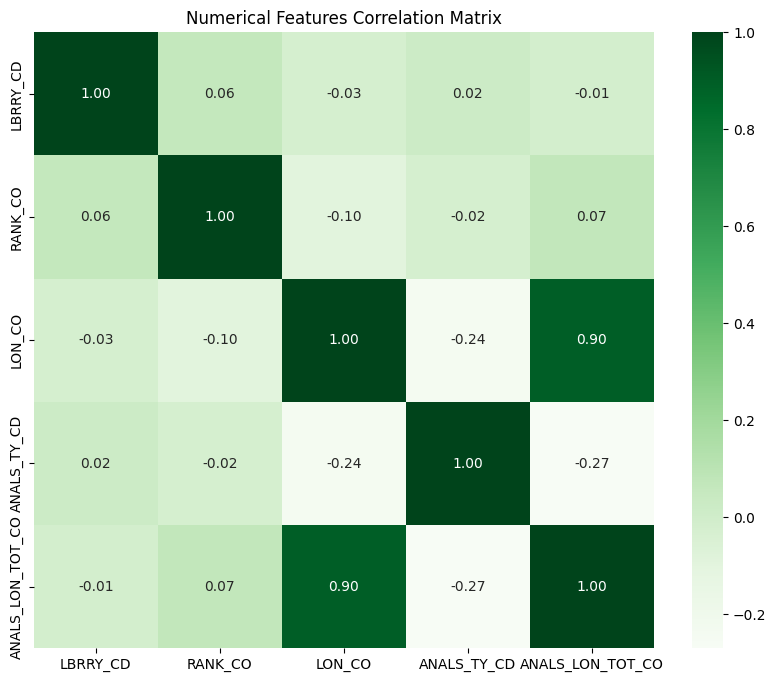

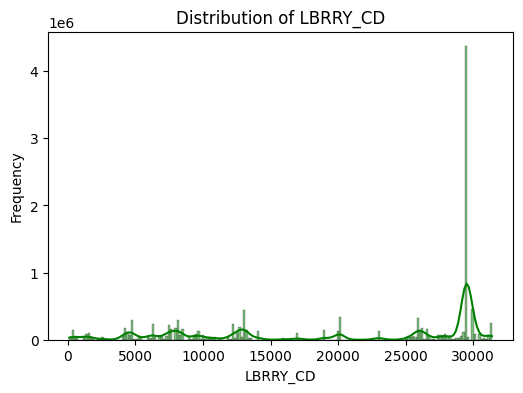

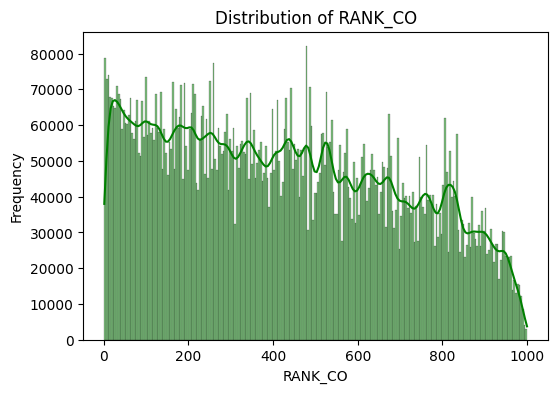

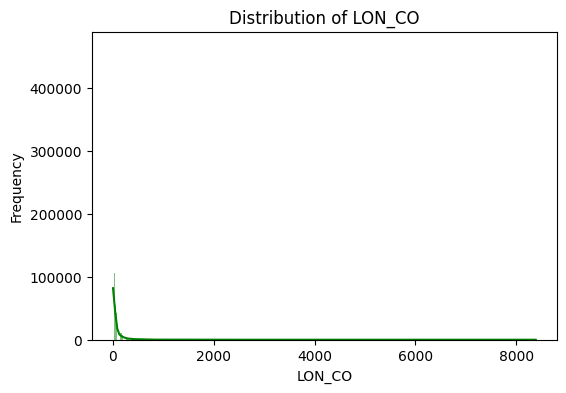

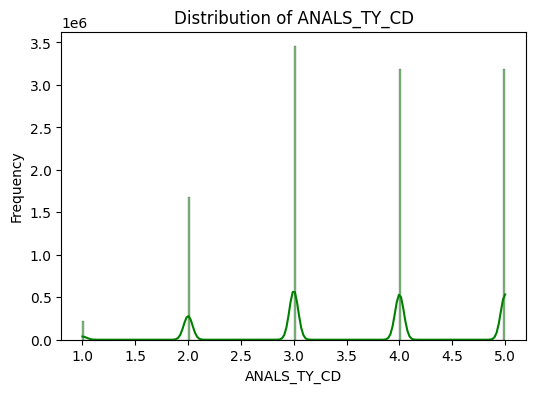

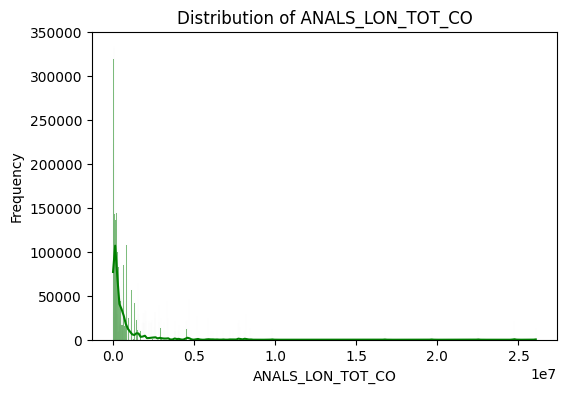


Value counts for ISBN_THIRTEEN_NO:
ISBN_THIRTEEN_NO
9788930000000.0    89083
9788959897001.0    68136
9791160000000.0    55734
9788993242706.0    43332
9788972756194.0    35438
Name: count, dtype: int64

Value counts for KDC_NM:
KDC_NM
813.8    1370885
813.7     737808
833.8     521695
843.0     436108
813.6     378731
Name: count, dtype: int64

Value counts for CL_SMBL_NO:
CL_SMBL_NO
813.8    1061717
813.8     600286
813.7     529238
833.8     410290
843       333436
Name: count, dtype: int64

Value counts for ANALS_PD_CD:
ANALS_PD_CD
p2    4115311
p1    3923705
p3    3685347
Name: count, dtype: int64

Value counts for AGE_FLAG_NM:
AGE_FLAG_NM
40대         1101415
50대         1009594
30대          993697
20대          905721
초등(8~13)     899398
Name: count, dtype: int64

Value counts for AREA_NM:
AREA_NM
서울    232827
인천    230238
경남    216489
부산    214611
충남    212825
Name: count, dtype: int64

Value counts for SEXDSTN_FLAG_NM:
SEXDSTN_FLAG_NM
여성    3347935
남성    3023311
Name: count, dt

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2. 기본 EDA 출력
print("데이터 형태:", data.shape)
print("\n상위 10개 행:")
print(data.head(10))
print("\n데이터 정보:")
data.info()
print("\n기초 통계량 (숫자형/범주형 포함):")
print(data.describe(include='all'))
print("\n컬럼별 결측치 개수:")
print(data.isnull().sum())

# 3. 숫자형 컬럼 선택 및 상관관계 행렬 시각화 (초록색 계열 cmap 사용)
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(data[num_cols].corr(), annot=True, cmap='Greens', fmt=".2f")
plt.title('Numerical Features Correlation Matrix')
plt.show()

# 4. 각 숫자형 컬럼의 분포 시각화 (histplot에 초록색 적용)
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col].dropna(), kde=True, color='green')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# 5. 범주형 컬럼의 값 분포 확인 (예: 상위 5개 값)
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"\nValue counts for {col}:")
    print(data[col].value_counts().head(5))


In [ ]:
!pip install koreanize-matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 39.2 MB/s eta 0:00:00


In [ ]:
import koreanize_matplotlib


<ipython-input-73-94271d5aae23>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Greens")
<ipython-input-73-94271d5aae23>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=kdc_group_counts_sorted.values/100, y=kdc_group_counts_sorted.index.astype(str), palette=colors)


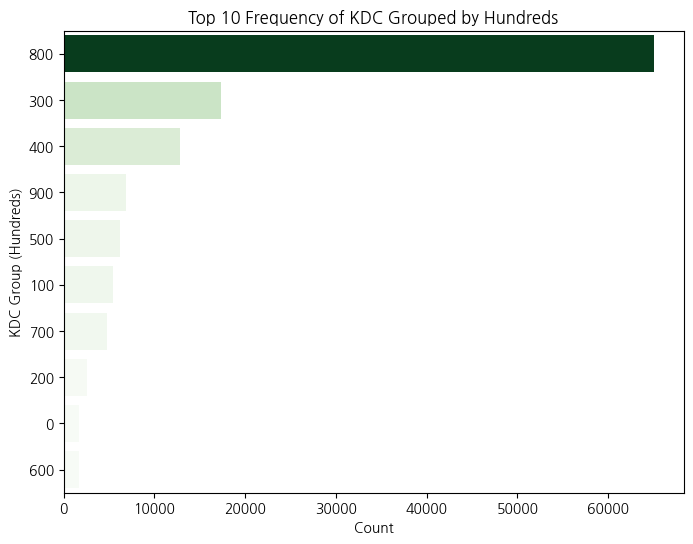

<ipython-input-73-94271d5aae23>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['ANALS_PD_CD'], palette="Greens")


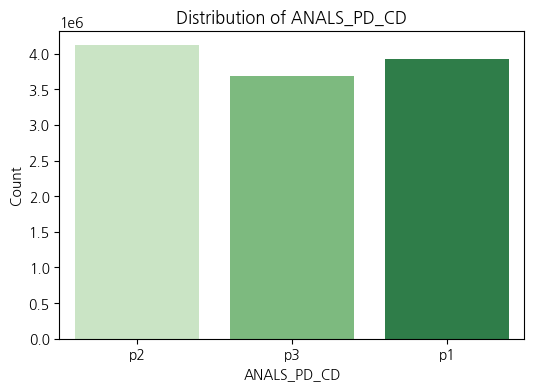

<ipython-input-73-94271d5aae23>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=age_counts_sorted.index, y=age_counts_sorted.values, palette=colors_age)


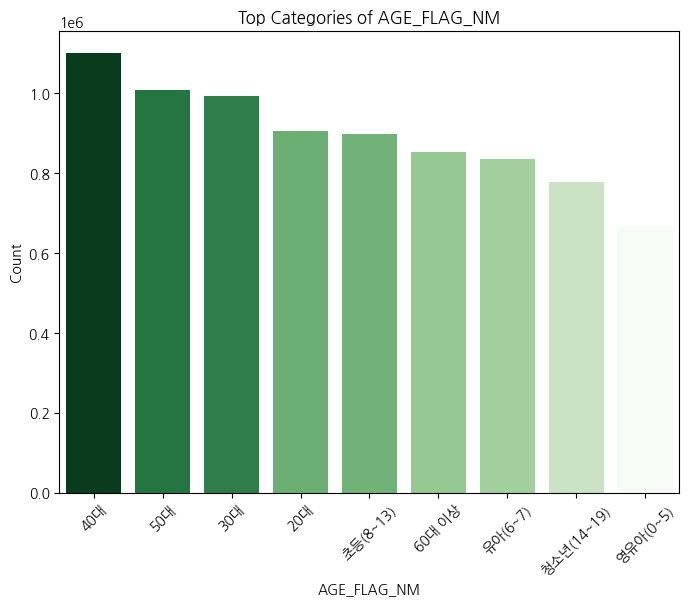

<ipython-input-73-94271d5aae23>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['SEXDSTN_FLAG_NM'], palette="Greens")


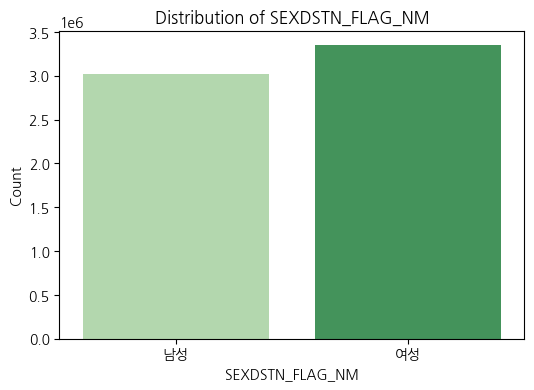

<ipython-input-73-94271d5aae23>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=area_counts_sorted.index, y=area_counts_sorted.values, palette=colors_area)


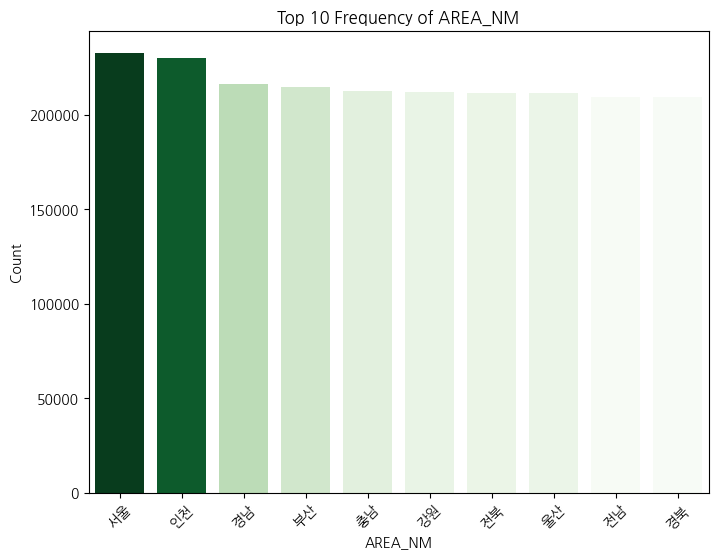

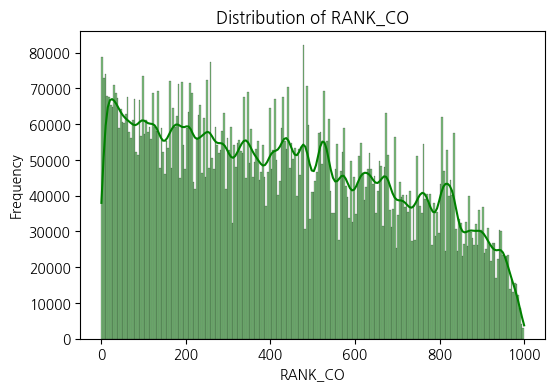

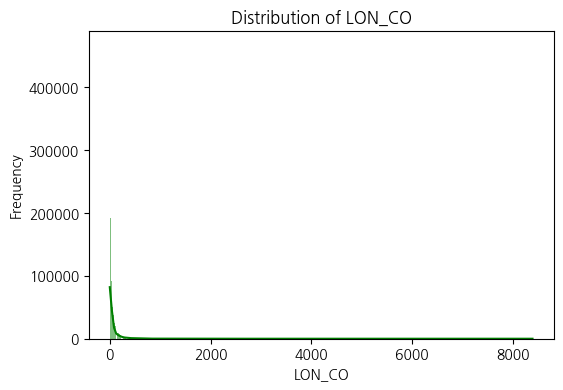

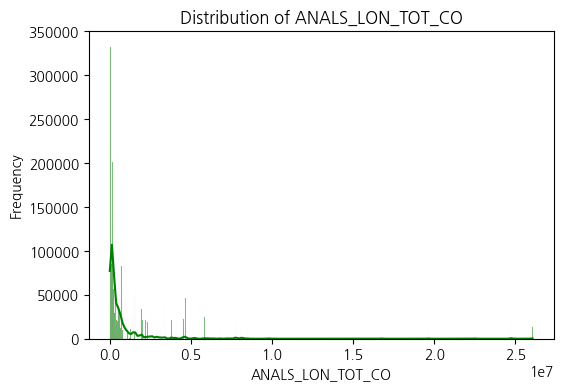

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# data 변수에 전체 데이터가 있다고 가정합니다.

# 1. KDC_NM - 상위 10개 카테고리 빈도수 (수평 막대그래프)
# 이미 백 단위 그룹화를 한 kdc_group_counts가 있다고 가정
# 내림차순 정렬
kdc_group_counts_sorted = kdc_group_counts.sort_values(ascending=False)

# count 값을 정규화하여 색상 생성 (값이 클수록 진한 초록색)
norm = mcolors.Normalize(vmin=kdc_group_counts_sorted.min(), vmax=kdc_group_counts_sorted.max())
cmap = cm.get_cmap("Greens")
colors = [cmap(norm(val)) for val in kdc_group_counts_sorted.values]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=kdc_group_counts_sorted.values/100, y=kdc_group_counts_sorted.index.astype(str), palette=colors)
plt.title("Top 10 Frequency of KDC Grouped by Hundreds")
plt.xlabel("Count")
plt.ylabel("KDC Group (Hundreds)")

ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
plt.show()

# 2. ANALS_PD_CD - 전체 분포 (범주가 3개 정도이므로) -> 그대로 countplot 사용
plt.figure(figsize=(6,4))
sns.countplot(x=data['ANALS_PD_CD'], palette="Greens")
plt.title("Distribution of ANALS_PD_CD")
plt.xlabel("ANALS_PD_CD")
plt.ylabel("Count")
plt.show()

# 3. AGE_FLAG_NM - 상위 10개 (내림차순 정렬 및 색상 진하기 적용)
age_counts = data['AGE_FLAG_NM'].value_counts().head(10)
age_counts_sorted = age_counts.sort_values(ascending=False)

norm_age = mcolors.Normalize(vmin=age_counts_sorted.min(), vmax=age_counts_sorted.max())
colors_age = [cmap(norm_age(val)) for val in age_counts_sorted.values]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=age_counts_sorted.index, y=age_counts_sorted.values, palette=colors_age)
plt.title("Top Categories of AGE_FLAG_NM")
plt.xlabel("AGE_FLAG_NM")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# 4. SEXDSTN_FLAG_NM - 전체 분포 (countplot 그대로 사용)
plt.figure(figsize=(6,4))
sns.countplot(x=data['SEXDSTN_FLAG_NM'], palette="Greens")
plt.title("Distribution of SEXDSTN_FLAG_NM")
plt.xlabel("SEXDSTN_FLAG_NM")
plt.ylabel("Count")
plt.show()

# 5. AREA_NM - 상위 10개 지역 (내림차순 정렬 및 색상 진하기 적용)
area_counts = data['AREA_NM'].value_counts().head(10)
area_counts_sorted = area_counts.sort_values(ascending=False)

norm_area = mcolors.Normalize(vmin=area_counts_sorted.min(), vmax=area_counts_sorted.max())
colors_area = [cmap(norm_area(val)) for val in area_counts_sorted.values]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=area_counts_sorted.index, y=area_counts_sorted.values, palette=colors_area)
plt.title("Top 10 Frequency of AREA_NM")
plt.xlabel("AREA_NM")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# ----- 수치형 변수 시각화 -----

numeric_cols = ['RANK_CO', 'LON_CO', 'ANALS_LON_TOT_CO']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col].dropna(), kde=True, color='green')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


## 2)  EDA: 합병 파일 (ready)

In [ ]:
load_path = '/content/drive/MyDrive/miniproject/data/ready.pkl'
data = pd.read_pickle(load_path)
data

,ANALS_TY,RANK_CO,LON_PROP,ANALS_PD_CD,KDC_NM,AREA,LBRRY_CD,Y
0,"(nan, nan, nan)",1001.0,0.000000,0,609.2,"(경기도, 포천시)",1501,0
1,"(50대, nan, 남성)",818.0,0.000066,p2,609.0,"(경기도, 포천시)",1501,1
2,"(50대, nan, 남성)",818.0,0.000066,p2,609.0,"(경기도, 포천시)",1501,1
3,"(60대 이상, nan, 남성)",816.0,0.000067,p3,609.0,"(경기도, 포천시)",1501,1
4,"(60대 이상, nan, 남성)",816.0,0.000067,p3,609.0,"(경기도, 포천시)",1501,1
...,...,...,...,...,...,...,...,...
12932076,"(nan, nan, nan)",1001.0,0.000000,0,530.04,"(경상북도, 울릉군)",29528,0
12932077,"(nan, nan, nan)",1001.0,0.000000,0,810.82,"(경상북도, 울릉군)",29528,0
12932078,"(nan, nan, nan)",1001.0,0.000000,0,234.8,"(경상북도, 울릉군)",29528,0
12932079,"(nan, nan, nan)",1001.0,0.000000,0,594.18,"(경상북도, 울릉군)",29528,0


In [ ]:
data.columns.tolist()

['ANALS_TY',
 'RANK_CO',
 'LON_PROP',
 'ANALS_PD_CD',
 'KDC_NM',
 'AREA',
 'LBRRY_CD',
 'Y']

데이터 형태: (12447902, 8)

상위 10개 행:
             ANALS_TY  RANK_CO  LON_PROP ANALS_PD_CD    KDC_NM        AREA  \
0     (nan, nan, nan)   1001.0  0.000000           0     609.2  (경기도, 포천시)   
1      (50대, nan, 남성)    818.0  0.000066          p2     609.0  (경기도, 포천시)   
2      (50대, nan, 남성)    818.0  0.000066          p2     609.0  (경기도, 포천시)   
3   (60대 이상, nan, 남성)    816.0  0.000067          p3     609.0  (경기도, 포천시)   
4   (60대 이상, nan, 남성)    816.0  0.000067          p3     609.0  (경기도, 포천시)   
5     (50대, nan, nan)    932.0  0.000064          p3     609.0  (경기도, 포천시)   
6  (60대 이상, nan, nan)    766.0  0.000060          p3     609.0  (경기도, 포천시)   
7      (50대, nan, 남성)    659.0  0.000073          p3     609.0  (경기도, 포천시)   
8      (50대, nan, 남성)    659.0  0.000073          p3     609.0  (경기도, 포천시)   
9     (nan, nan, nan)   1001.0  0.000000           0  375.4802  (경기도, 포천시)   

  LBRRY_CD  Y  
0     1501  0  
1     1501  1  
2     1501  1  
3     1501  1  
4     1501  1  
5     1501  

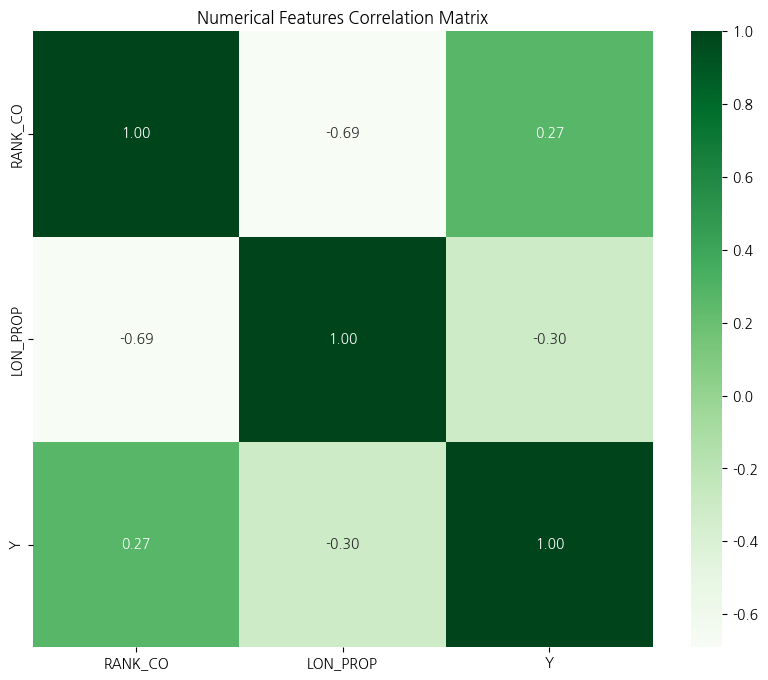

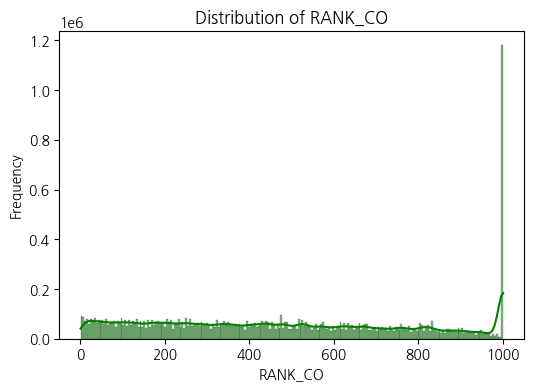

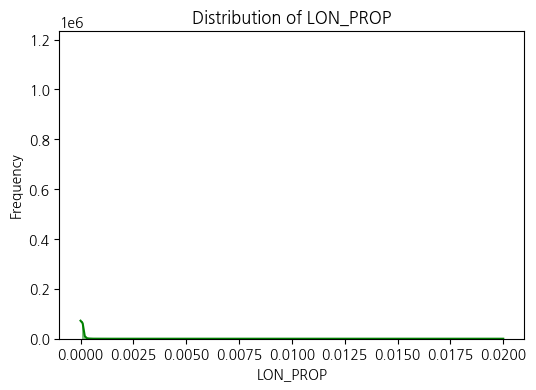

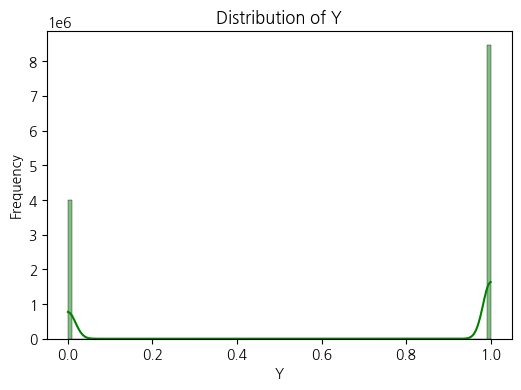

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2. 기본 EDA 출력
print("데이터 형태:", data.shape)
print("\n상위 10개 행:")
print(data.head(10))
print("\n데이터 정보:")
data.info()
print("\n기초 통계량 (숫자형/범주형 포함):")
print(data.describe(include='all'))
print("\n컬럼별 결측치 개수:")
print(data.isnull().sum())

# 3. 숫자형 컬럼 선택 및 상관관계 행렬 시각화 (초록색 계열 cmap 사용)
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(data[num_cols].corr(), annot=True, cmap='Greens', fmt=".2f")
plt.title('Numerical Features Correlation Matrix')
plt.show()

# 4. 각 숫자형 컬럼의 분포 시각화 (histplot에 초록색 적용)
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col].dropna(), kde=True, color='green')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# 5. 범주형 컬럼의 값 분포 확인 (예: 상위 5개 값)
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"\nValue counts for {col}:")
    print(data[col].value_counts().head(5))


In [ ]:
!pip install koreanize-matplotlib


In [ ]:
import koreanize_matplotlib


<ipython-input-84-47b28980eb65>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Greens")
<ipython-input-84-47b28980eb65>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=kdc_group_counts_sorted.index.astype(str), y=kdc_group_counts_sorted.values/100, palette=colors)


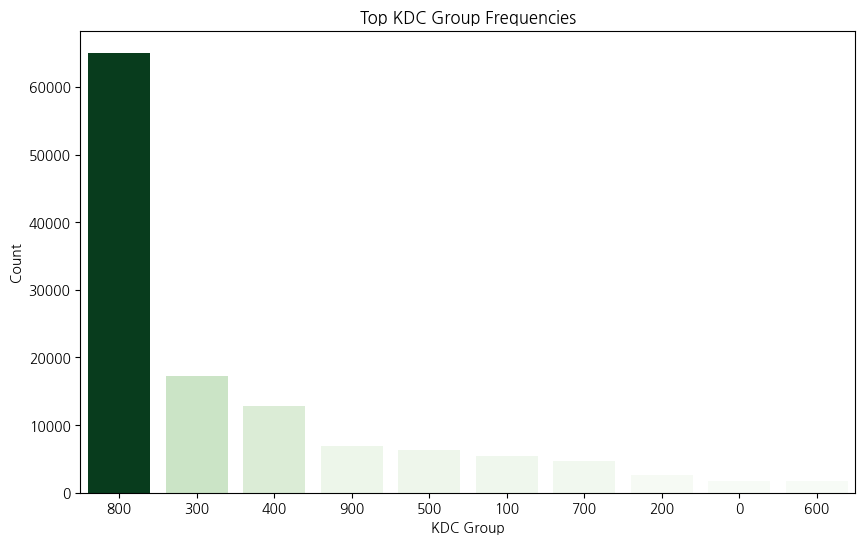

<ipython-input-84-47b28980eb65>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['ANALS_PD_CD'], palette="Greens")


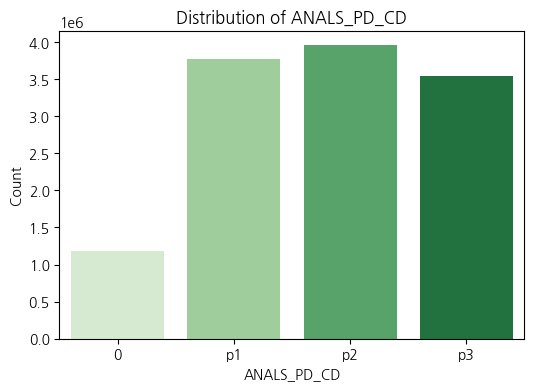

<ipython-input-84-47b28980eb65>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=age_counts.index, y=age_counts.values, palette=colors_age)


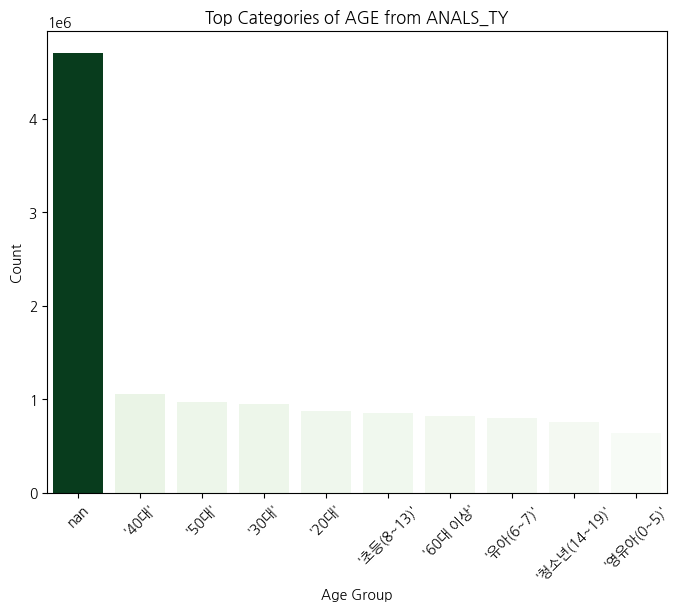

<ipython-input-84-47b28980eb65>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['GENDER'], palette="Greens")


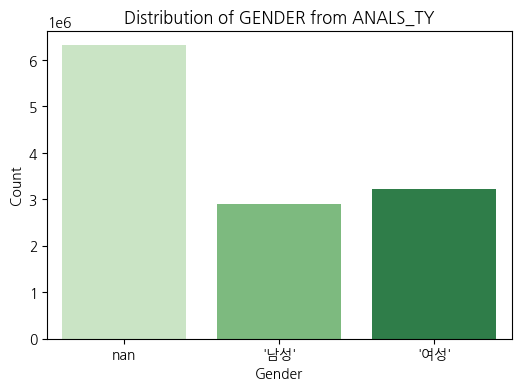

<ipython-input-84-47b28980eb65>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=region_counts.index, y=region_counts.values, palette=colors_region)


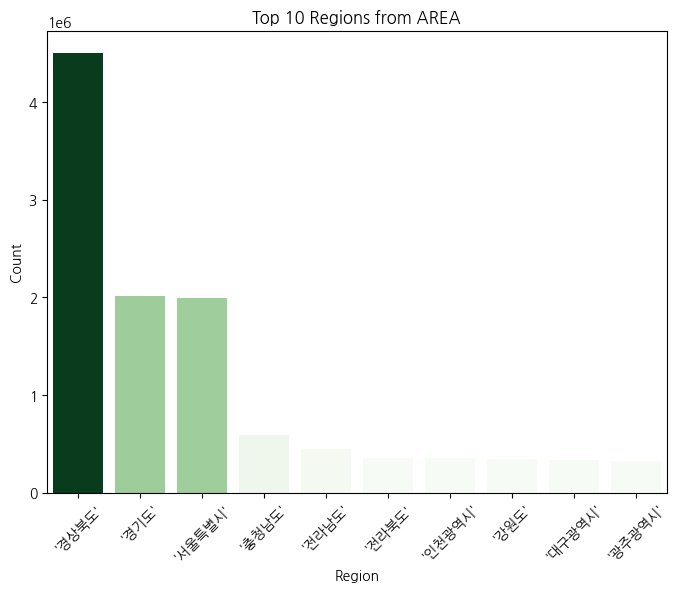

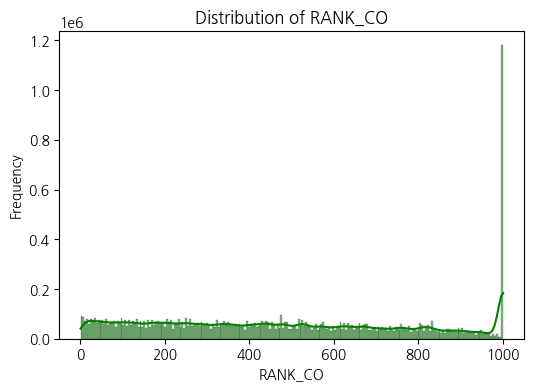

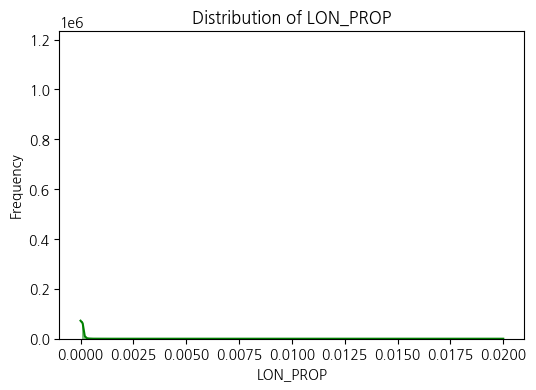

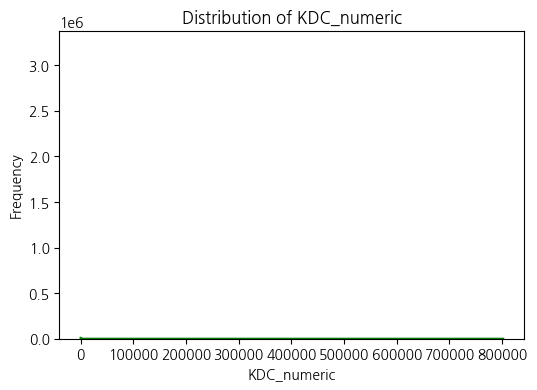

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# -------------------------
# 1. KDC_NM 처리 및 백 단위 그룹화
# -------------------------
data['KDC_numeric'] = pd.to_numeric(data['KDC_NM'], errors='coerce')
data_clean = data.dropna(subset=['KDC_numeric']).copy()
data_clean['KDC_int'] = data_clean['KDC_numeric'].astype(int)
data_clean['KDC_group'] = (data_clean['KDC_int'] // 100) * 100

# 백 단위 그룹별 빈도 집계 및 정렬
kdc_group_counts = data_clean['KDC_group'].value_counts().sort_index()
# 900 이하의 그룹만 선택
kdc_group_counts = kdc_group_counts[kdc_group_counts.index <= 900]
# 내림차순 정렬 (빈도수가 높은 순)
kdc_group_counts_sorted = kdc_group_counts.sort_values(ascending=False)

# 색상 매핑: 값이 클수록 진한 초록색 (Greens 계열)
norm = mcolors.Normalize(vmin=kdc_group_counts_sorted.min(), vmax=kdc_group_counts_sorted.max())
cmap = cm.get_cmap("Greens")
colors = [cmap(norm(val)) for val in kdc_group_counts_sorted.values]

# 그래프 그리기: x축은 KDC 그룹, y축은 빈도수를 100으로 나눈 값 (백 단위)
plt.figure(figsize=(10,6))
ax = sns.barplot(x=kdc_group_counts_sorted.index.astype(str), y=kdc_group_counts_sorted.values/100, palette=colors)
plt.title("Top KDC Group Frequencies")
plt.xlabel("KDC Group")
plt.ylabel("Count")
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
plt.show()


# -------------------------
# 2. ANALS_PD_CD 시각화
# -------------------------
plt.figure(figsize=(6,4))
sns.countplot(x=data['ANALS_PD_CD'], palette="Greens")
plt.title("Distribution of ANALS_PD_CD")
plt.xlabel("ANALS_PD_CD")
plt.ylabel("Count")
plt.show()


# -------------------------
# 3. ANALS_TY에서 연령대 및 성별 추출
# -------------------------
# ANALS_TY 컬럼을 우선 object로 변환한 후, 문자열로 처리
data['ANALS_TY'] = data['ANALS_TY'].astype('object').astype(str)
data['ANALS_TY_clean'] = data['ANALS_TY'].str.strip("()")

def extract_age(x):
    parts = x.split(",")
    if len(parts) >= 1:
        return parts[0].strip()
    return None

def extract_gender(x):
    parts = x.split(",")
    if len(parts) >= 3:
        return parts[2].strip()
    return None

data['AGE'] = data['ANALS_TY_clean'].apply(extract_age)
data['GENDER'] = data['ANALS_TY_clean'].apply(extract_gender)

# AGE 분포 시각화 (내림차순 정렬, 색상 진하게)
age_counts = data['AGE'].value_counts().sort_values(ascending=False).head(10)
norm_age = mcolors.Normalize(vmin=age_counts.min(), vmax=age_counts.max())
colors_age = [cmap(norm_age(val)) for val in age_counts.values]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=age_counts.index, y=age_counts.values, palette=colors_age)
plt.title("Top Categories of AGE from ANALS_TY")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# GENDER 분포 시각화
plt.figure(figsize=(6,4))
sns.countplot(x=data['GENDER'], palette="Greens")
plt.title("Distribution of GENDER from ANALS_TY")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


# -------------------------
# 4. AREA에서 지역 추출
# -------------------------
# AREA 컬럼을 object로 변환 후 문자열 처리
data['AREA'] = data['AREA'].astype('object').astype(str)
data['REGION'] = data['AREA'].str.strip("()").apply(lambda x: x.split(",")[0].strip() if x != "nan" and len(x.split(","))>=1 else None)
region_counts = data['REGION'].value_counts().sort_values(ascending=False).head(10)
norm_region = mcolors.Normalize(vmin=region_counts.min(), vmax=region_counts.max())
colors_region = [cmap(norm_region(val)) for val in region_counts.values]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=region_counts.index, y=region_counts.values, palette=colors_region)
plt.title("Top 10 Regions from AREA")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# -------------------------
# 5. 수치형 변수 시각화
# -------------------------
numeric_cols = ['RANK_CO', 'LON_PROP', 'KDC_numeric']
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col].dropna(), kde=True, color='green')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


# **3. 피처 엔지니어링**

### 데이터 살펴보기

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12932081 entries, 0 to 12932080
Data columns (total 21 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   ISBN_THIRTEEN_NO           object 
 1   LBRRY_CD                   Int64  
 2   KDC_NM_x                   object 
 3   CL_SMBL_NO                 object 
 4   RANK_CO                    float64
 5   LON_CO                     float64
 6   ANALS_PD_CD                object 
 7   ANALS_TY_CD                float64
 8   AGE_FLAG_NM                object 
 9   AREA_NM                    object 
 10  SEXDSTN_FLAG_NM            object 
 11  ANALS_LON_TOT_CO           float64
 12  ADTION_SMBL_NM             object 
 13  PRC_VALUE                  float64
 14  TWO_PBLICTE_DE             object 
 15  INTNT_BOOKST_BOOK_EXST_AT  object 
 16  PORTAL_SITE_BOOK_EXST_AT   object 
 17  LBRRY_NM                   object 
 18  LBRRY_ADDR                 object 
 19  ONE_AREA_NM                object 
 20  

In [ ]:
data.describe(include = 'float64')

,RANK_CO,LON_CO,ANALS_TY_CD,ANALS_LON_TOT_CO,PRC_VALUE
count,1.172436e+07,1.172436e+07,1.172436e+07,1.172436e+07,15749.000000
mean,4.262935e+02,9.049818e+01,3.634077e+00,8.442730e+05,15921.057146
std,2.718006e+02,2.166710e+02,1.084289e+00,2.092613e+06,19174.433128
min,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+01,0.000000
25%,1.910000e+02,1.100000e+01,3.000000e+00,9.490600e+04,12000.000000
50%,4.070000e+02,3.000000e+01,4.000000e+00,2.712170e+05,14000.000000
75%,6.450000e+02,8.000000e+01,5.000000e+00,7.149200e+05,17000.000000
max,1.000000e+03,8.389000e+03,5.000000e+00,2.606628e+07,720000.000000


-> RANK_CO 사분위 값 : Y값 생성에 사용

In [ ]:
data.describe(include='object')

,ISBN_THIRTEEN_NO,KDC_NM_x,CL_SMBL_NO,ANALS_PD_CD,AGE_FLAG_NM,AREA_NM,SEXDSTN_FLAG_NM,ADTION_SMBL_NM,TWO_PBLICTE_DE,INTNT_BOOKST_BOOK_EXST_AT,PORTAL_SITE_BOOK_EXST_AT,LBRRY_NM,LBRRY_ADDR,ONE_AREA_NM,OPNNG_TIME
count,12932081,12447902.0,12472990,11724363,8046903,3453924,6371246,16180.0,15555,11494,11494,12932081,12932081,12932081,12686836
unique,539122,20429.0,22062,3,9,17,2,773.0,2189,1,1,872,871,17,491
top,9788930000000.0,813.8,813.8,p2,40대,서울,여성,3810.0,2021-09-10,Y,Y,익산시립영등도서관,전라북도 익산시 궁동로 57,경상북도,"평일 09:00~18:00, 주말 09:00~17:00"
freq,89083,1370885.0,1061717,4115311,1101415,232827,3347935,1322.0,365,11494,11494,273385,273385,4519674,760332


In [ ]:
df_numeric = data.select_dtypes(include = ['int32', 'float64'])
df_obj = data.select_dtypes(include = 'object')
df_cat = [col for col in df_obj.columns if data[col].nunique() <= 10]
df_obj.drop(columns = df_cat, inplace = True)

In [ ]:
for col in df_cat:
  print(f'{col} : {data[col].unique()}')

ANALS_PD_CD : [nan 'p2' 'p3' 'p1']
AGE_FLAG_NM : [nan '50대' '60대 이상' '30대' '40대' '20대' '청소년(14~19)' '초등(8~13)' '영유아(0~5)'
 '유아(6~7)']
SEXDSTN_FLAG_NM : [nan '남성' '여성']
INTNT_BOOKST_BOOK_EXST_AT : [nan 'Y']
PORTAL_SITE_BOOK_EXST_AT : [nan 'Y']


- 칼럼 합치기
  - ANALS_TY(분석 유형) - 나이, 지역, 성별
  - AREA(도서관 지역) - 시/도, 시/군/구

In [ ]:
# ANALS
data['ANALS_TY'] = pd.Series(list(zip(data['AGE_FLAG_NM'], data['AREA_NM'], data['SEXDSTN_FLAG_NM'])))

# AREA
data['AREA'] = pd.Series(list(zip(data['ONE_AREA_NM'], data['TWO_AREA_NM'])))


- 결측치 값 대체
  - ANALS_PD_CD: 0 (분석기간 X)
  - ANALS_LON_TOT_CO: 0 (분석 X -> 총 분석 권수: 0)
  - KDC_NM -> 결측치 존재 행 삭제 ; 484,179행

In [ ]:
# 🔹 결측치 대체 (우선 처리: inplace 사용 줄이고 chaining 방식 사용)
data = (
    data
    .assign(
        RANK_CO = data['RANK_CO'].fillna(1001),
        ANALS_PD_CD = data['ANALS_PD_CD'].fillna(0),
        ANALS_LON_TOT_CO = data['ANALS_LON_TOT_CO'].fillna(0),
    )
    .dropna(subset=['KDC_NM'])
)

- 파생변수 생성: LON_PROP
  1. LON_PROP
  - 대출수/분석대출총수 -> 각 분석 유형에서 해당 책이 차지하는 대출율
  - 인기 순위에 해당하지 않는 책의 대출율을 0으로 대체

  2. KDC 나누기
  - 대분류
  - 소분류

In [ ]:
data['LON_PROP'] = data['LON_CO'] / data['ANALS_LON_TOT_CO']
data.loc[data['ANALS_LON_TOT_CO'] == 0, 'LON_PROP'] = 0

- 필요한 칼럼만 선택

In [ ]:
data = data[['ANALS_TY', 'LON_PROP', 'ANALS_PD_CD', 'KDC_H', 'KDC_T', 'AREA', 'LBRRY_CD', 'Y']]

- 변수 타입 변경
  - LBRRY_CD (정수형 -> 범주형으로)
  - object형 모두 category로 (인코딩 없이 트리 기반 모델에서 활용 위함)

In [ ]:
# LBRRY_CD
data['LBRRY_CD'] = data['LBRRY_CD'].astype('category')

# object -> category
obj_cols = data.select_dtypes(include = 'object').columns
data[obj_cols] = data[obj_cols].astype('category')

- 최종 데이터

In [ ]:
data.head(5)

,ANALS_TY,RANK_CO,LON_PROP,ANALS_PD_CD,KDC_NM,AREA,LBRRY_CD,Y
0,"(nan, nan, nan)",1001.0,0.000000,0,609.2,"(경기도, 포천시)",1501,0
1,"(50대, nan, 남성)",818.0,0.000066,p2,609.0,"(경기도, 포천시)",1501,0
2,"(50대, nan, 남성)",818.0,0.000066,p2,609.0,"(경기도, 포천시)",1501,0
3,"(60대 이상, nan, 남성)",816.0,0.000067,p3,609.0,"(경기도, 포천시)",1501,0
4,"(60대 이상, nan, 남성)",816.0,0.000067,p3,609.0,"(경기도, 포천시)",1501,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12447902 entries, 0 to 12932080
Data columns (total 8 columns):
 #   Column       Dtype   
---  ------       -----   
 0   ANALS_TY     category
 1   RANK_CO      float64 
 2   LON_PROP     float64 
 3   ANALS_PD_CD  category
 4   KDC_NM       category
 5   AREA         category
 6   LBRRY_CD     category
 7   Y            int64   
dtypes: category(5), float64(2), int64(1)
memory usage: 475.6 MB


In [ ]:
data.isnull().sum()

,0
ANALS_TY,0
RANK_CO,0
LON_PROP,0
ANALS_PD_CD,0
KDC_NM,0
AREA,0
LBRRY_CD,0
Y,0


In [ ]:
data.to_pickle('/content/drive/MyDrive/miniproject/data/ready.pkl')

### ** 심폐소생 실패의 현장...

#### - 인구 데이터

In [ ]:
load_path = '/content/drive/MyDrive/miniproject/data/loan_information.csv'
data = pd.read_csv(load_path)
data

<ipython-input-4-4bfc5d1c4bd7>:2: DtypeWarning: Columns (11,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(load_path)


,SEQ_NO,RANK_CO,INPT_DE,ISBN_THIRTEEN_NO,BOOK_TITLE_NM,AUTHR_NM,BOOK_INTRCN_CN,PUBLISHER_NM,PBLICTE_DE,BOOK_IMAGE_NM,...,LON_CO,ANALS_PD_CD,ANALS_PD_CD_NM,ANALS_TY_CD,ANALS_TY_CD_NM,AGE_FLAG_NM,AREA_NM,SEXDSTN_FLAG_NM,VLM_NM,ANALS_LON_TOT_CO
0,198841476,629,2020-03-15,9.788910e+12,멋쟁이 낸시는 실수투성이 미용사,제인 오코너 글 ;김영선 옮김,국민서관 그림동화 시리즈 160권. 주인공 낸시가 학급 기념사진을 찍기 전날 혼자 ...,국민서관,2014,https://bookthumb-phinf.pstatic.net/cover/079/...,...,1,p1,7일,3,지역별,NaN,경남,NaN,160,6811
1,198841475,629,2020-03-15,9.788910e+12,"지글아, 어디 숨었니? :재미난 플랩북",지은이: 로렌 차일드 ;옮긴이: 문상수,찰리와 롤라 시리즈. &lt;난 토마토 절대 안 먹어&gt;로 오랫동안 독자들의 많...,국민서관,2013,http://image.aladin.co.kr/product/3269/40/cove...,...,1,p1,7일,3,지역별,NaN,경남,NaN,NaN,6811
2,198841473,629,2020-03-15,9.788910e+12,내가 책이라면,쥬제 죠르즈 레트리아 글 ;임은숙 옮김,"2013년 제2회 CJ그림책애니메이션 선정작. 스페인 바르셀로나 시 수업 상, 브라...",국민서관,2012,http://image.aladin.co.kr/product/2125/6/cover...,...,1,p1,7일,3,지역별,NaN,경남,NaN,144,6811
3,198841474,629,2020-03-15,9.788910e+12,멋쟁이 낸시의 별자리 여행,제인 오코너 글 ;김영선 옮김,국민서관 그림동화 시리즈 148권. 주인공 낸시가 별자리 감상을 준비하는 하루 동안...,국민서관,2013,https://bookthumb-phinf.pstatic.net/cover/072/...,...,1,p1,7일,3,지역별,NaN,경남,NaN,148,6811
4,198841472,629,2020-03-15,9.788910e+12,멋쟁이 낸시의 학교생활 100일,제인 오코너 글 ;김영선 옮김,국민서관 그림동화 시리즈 136권. 학교생활 100일을 기념해 뭔가 상상력 넘치는 ...,국민서관,2012,http://image.aladin.co.kr/product/1672/14/cove...,...,1,p1,7일,3,지역별,NaN,경남,NaN,136,6811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498527,309256549,53,2021-12-15,9.788936e+12,당근 유치원,지은이: 안녕달,2015년 &lt;수박 수영장&gt;을 발표한 이후 개성 있는 작품들을 연달아 선보...,창비,2020,https://image.aladin.co.kr/product/24011/82/co...,...,8,p1,7일,3,지역별,NaN,전남,NaN,NaN,31156
1498528,309256548,40,2021-12-15,9.791191e+12,(강방천&존리와 함께하는) 나의 첫 주식 교과서 :기본부터 제대로 배우는 평생 투자...,"지은이: 강방천,일러스트: 정민영","이제 막 투자를 시작하는 사람들, 투자하고 있지만 확신이 없는 개인 투자자를 위한 ...",Page2(페이지2북스),2021,https://image.aladin.co.kr/product/27524/96/co...,...,9,p1,7일,3,지역별,NaN,전남,NaN,NaN,31156
1498529,309256547,40,2021-12-15,9.791190e+12,(백종원의) 도전 요리왕 :음식으로 맛보는 세계 역사 문화 체험,"글: 백종원,그림: 이정태",음식과 문화에 대한 해박한 지식과 구수한 입담을 자랑하는 만능 요리 연구가 백종원이...,위즈덤하우스 미디어그룹,2019,https://image.aladin.co.kr/product/21713/69/co...,...,9,p1,7일,3,지역별,NaN,전남,NaN,3,31156
1498530,309256497,1,2021-12-15,9.791164e+12,(이상한 과자 가게) 전천당,히로시마 레이코 글;김정화 옮김,"화제의 베스트셀러, 《이상한 과자 가게 전천당》 시리즈. 4권에서는 요도미가 &lt...",길벗스쿨,2019-2020,https://image.aladin.co.kr/product/21439/72/co...,...,17,p1,7일,3,지역별,NaN,전남,NaN,4,31156


In [ ]:
# INPT_DE 열을 datetime 형식으로 변환
data['INPT_DE'] = pd.to_datetime(data['INPT_DE'], errors='coerce')

# 변환된 값 중 최솟값과 최댓값 출력
min_date = data['INPT_DE'].min()
max_date = data['INPT_DE'].max()

print("📅 INPT_DE 최소 날짜:", min_date)
print("📅 INPT_DE 최대 날짜:", max_date)


📅 INPT_DE 최소 날짜: 2020-03-15 00:00:00
📅 INPT_DE 최대 날짜: 2021-12-15 00:00:00


In [ ]:
load_path = '/content/drive/MyDrive/miniproject/data/ready.pkl'
dat = pd.read_pickle(load_path)
dat

,ANALS_TY,RANK_CO,LON_PROP,ANALS_PD_CD,KDC_NM,AREA,LBRRY_CD,Y
0,"(nan, nan, nan)",1001.0,0.000000,0,609.2,"(경기도, 포천시)",1501,0
1,"(50대, nan, 남성)",818.0,0.000066,p2,609.0,"(경기도, 포천시)",1501,0
2,"(50대, nan, 남성)",818.0,0.000066,p2,609.0,"(경기도, 포천시)",1501,0
3,"(60대 이상, nan, 남성)",816.0,0.000067,p3,609.0,"(경기도, 포천시)",1501,0
4,"(60대 이상, nan, 남성)",816.0,0.000067,p3,609.0,"(경기도, 포천시)",1501,0
...,...,...,...,...,...,...,...,...
12932076,"(nan, nan, nan)",1001.0,0.000000,0,530.04,"(경상북도, 울릉군)",29528,0
12932077,"(nan, nan, nan)",1001.0,0.000000,0,810.82,"(경상북도, 울릉군)",29528,0
12932078,"(nan, nan, nan)",1001.0,0.000000,0,234.8,"(경상북도, 울릉군)",29528,0
12932079,"(nan, nan, nan)",1001.0,0.000000,0,594.18,"(경상북도, 울릉군)",29528,0


In [ ]:
# 값 별 개수 (NaN 포함)
dat['ANALS_TY'].value_counts(dropna=False)

,count
ANALS_TY,
"(nan, nan, nan)",1391470
"('40대', nan, '여성')",447022
"('50대', nan, '여성')",412524
"('30대', nan, '여성')",403667
"('40대', nan, '남성')",391618
"('20대', nan, '여성')",371412
"('60대 이상', nan, '여성')",362698
"('50대', nan, '남성')",356681
"('초등(8~13)', nan, '여성')",355500


In [ ]:
load_path = '/content/drive/MyDrive/miniproject/data/pp.csv'
data = 0
data = pd.read_csv(load_path, encoding='cp949')
data

,행정구역,2021년_남_총인구수,2021년_남_연령구간인구수,2021년_남_0~9세,2021년_남_10~19세,2021년_남_20~29세,2021년_남_30~39세,2021년_남_40~49세,2021년_남_50~59세,2021년_남_60~69세,...,2021년_여_10~19세,2021년_여_20~29세,2021년_여_30~39세,2021년_여_40~49세,2021년_여_50~59세,2021년_여_60~69세,2021년_여_70~79세,2021년_여_80~89세,2021년_여_90~99세,2021년_여_100세 이상
0,서울특별시 (1100000000),"4,618,040","4,618,040","299,764","387,691","684,530","718,763","733,371","742,757","607,114",...,"368,445","737,747","720,516","747,409","764,437","678,808","379,292","178,485","31,098","1,262"
1,서울특별시 종로구 (1111000000),"70,183","70,183","3,540","5,157","10,973","9,707","10,136","12,574","10,139",...,"5,224","11,829","9,763","10,833","12,383","10,213","6,461","3,667",660,23
2,서울특별시 중구 (1114000000),"59,630","59,630","3,265","3,206","8,477","9,909","8,898","10,166","9,023",...,"3,268","9,832","9,977","8,481","9,877","9,060","5,588","3,146",591,15
3,서울특별시 용산구 (1117000000),"107,210","107,210","6,523","7,444","15,432","18,641","16,651","17,821","14,068",...,"7,248","17,346","19,078","17,130","18,301","15,101","8,983","5,385",990,51
4,서울특별시 성동구 (1120000000),"139,380","139,380","9,797","9,436","21,395","23,032","21,733","22,846","18,458",...,"9,467","22,068","23,783","21,613","23,308","19,310","11,160","5,583",859,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,경상남도 거창군 (4888000000),"29,955","29,955","1,827","3,125","3,347","2,485","3,787","5,389","5,328",...,"2,693","2,320","2,270","3,657","4,905","5,517","4,035","3,422",609,21
288,경상남도 합천군 (4889000000),"20,765","20,765",743,"1,210","1,599","1,311","2,247","4,031","4,921",...,"1,095","1,162","1,043","1,733","3,160","4,727","4,051","3,900",586,19
289,제주특별자치도 (5000000000),"339,177","339,177","29,782","36,810","42,819","40,755","56,996","59,685","42,122",...,"33,559","38,104","40,271","54,255","55,220","42,755","24,870","16,607","3,551",185
290,제주특별자치도 제주시 (5011000000),"246,494","246,494","22,456","27,577","32,756","30,996","41,482","42,419","28,963",...,"25,225","29,500","30,504","40,354","40,244","29,536","16,582","10,802","2,438",115


In [ ]:
# 기존 전처리
dat['ANALS_TY'] = dat['ANALS_TY'].apply(str)
dat[['AGE', 'REGION', 'GENDER']] = dat['ANALS_TY'].str.split(",", expand=True).apply(lambda col: col.str.strip())
dat['AREA'] = dat['AREA'].apply(str)
dat[['PROVINCE', 'CITY']] = dat['AREA'].str.split(",", expand=True).apply(lambda col: col.str.strip())

# 괄호/따옴표 제거 추가!
for col in ['AGE', 'GENDER', 'PROVINCE', 'CITY']:
    dat[col] = dat[col].str.replace("['()]", "", regex=True).str.strip()

# 인구 컬럼 생성
dat['인구컬럼'] = '2021년_' + dat['GENDER'] + '_' + dat['AGE']
dat['행정구역'] = dat['PROVINCE'] + ' ' + dat['CITY']
dat['총인구컬럼'] = '2021년_' + dat['GENDER'] + '_총인구수'
# '남성' → '남', '여성' → '여'
dat['GENDER'] = dat['GENDER'].replace({'남성': '남', '여성': '여'})
dat

,ANALS_TY,RANK_CO,LON_PROP,ANALS_PD_CD,KDC_NM,AREA,LBRRY_CD,Y,AGE,REGION,GENDER,PROVINCE,CITY,인구컬럼,행정구역,총인구컬럼,특성인구수,총인구수,pp
0,"(nan, nan, nan)",1001.0,0.000000,0,609.2,"('경기도', '포천시')",1501,0,nan,nan,nan,경기도,포천시,2021년_nan_nan,경기도 포천시,2021년_nan_총인구수,NaN,None,NaN
1,"('50대', nan, '남성')",818.0,0.000066,p2,609.0,"('경기도', '포천시')",1501,0,50대,nan,남,경기도,포천시,2021년_남성_50대,경기도 포천시,2021년_남성_총인구수,NaN,None,NaN
2,"('50대', nan, '남성')",818.0,0.000066,p2,609.0,"('경기도', '포천시')",1501,0,50대,nan,남,경기도,포천시,2021년_남성_50대,경기도 포천시,2021년_남성_총인구수,NaN,None,NaN
3,"('60대 이상', nan, '남성')",816.0,0.000067,p3,609.0,"('경기도', '포천시')",1501,0,60대 이상,nan,남,경기도,포천시,2021년_남성_60대 이상,경기도 포천시,2021년_남성_총인구수,NaN,None,NaN
4,"('60대 이상', nan, '남성')",816.0,0.000067,p3,609.0,"('경기도', '포천시')",1501,0,60대 이상,nan,남,경기도,포천시,2021년_남성_60대 이상,경기도 포천시,2021년_남성_총인구수,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12447897,"(nan, nan, nan)",1001.0,0.000000,0,530.04,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN
12447898,"(nan, nan, nan)",1001.0,0.000000,0,810.82,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN
12447899,"(nan, nan, nan)",1001.0,0.000000,0,234.8,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN
12447900,"(nan, nan, nan)",1001.0,0.000000,0,594.18,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN


In [ ]:
age_mapping = {
    '영유아(0~5)': '0~9세',
    '유아(6~7)': '0~9세',
    '초등(8~13)': '0~9세',
    '청소년(14~19)': '10~19세',
    '20대': '20~29세',
    '30대': '30~39세',
    '40대': '40~49세',
    '50대': '50~59세',
    '60대 이상': '60~69세'  # 또는 더 세분화해서 복수 합산
}
dat['AGE'] = dat['AGE'].replace(age_mapping)
dat

,ANALS_TY,RANK_CO,LON_PROP,ANALS_PD_CD,KDC_NM,AREA,LBRRY_CD,Y,AGE,REGION,GENDER,PROVINCE,CITY,인구컬럼,행정구역,총인구컬럼,특성인구수,총인구수,pp
0,"(nan, nan, nan)",1001.0,0.000000,0,609.2,"('경기도', '포천시')",1501,0,nan,nan,nan,경기도,포천시,2021년_nan_nan,경기도 포천시,2021년_nan_총인구수,NaN,None,NaN
1,"('50대', nan, '남성')",818.0,0.000066,p2,609.0,"('경기도', '포천시')",1501,0,50~59세,nan,남,경기도,포천시,2021년_남성_50대,경기도 포천시,2021년_남성_총인구수,NaN,None,NaN
2,"('50대', nan, '남성')",818.0,0.000066,p2,609.0,"('경기도', '포천시')",1501,0,50~59세,nan,남,경기도,포천시,2021년_남성_50대,경기도 포천시,2021년_남성_총인구수,NaN,None,NaN
3,"('60대 이상', nan, '남성')",816.0,0.000067,p3,609.0,"('경기도', '포천시')",1501,0,60~69세,nan,남,경기도,포천시,2021년_남성_60대 이상,경기도 포천시,2021년_남성_총인구수,NaN,None,NaN
4,"('60대 이상', nan, '남성')",816.0,0.000067,p3,609.0,"('경기도', '포천시')",1501,0,60~69세,nan,남,경기도,포천시,2021년_남성_60대 이상,경기도 포천시,2021년_남성_총인구수,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12447897,"(nan, nan, nan)",1001.0,0.000000,0,530.04,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN
12447898,"(nan, nan, nan)",1001.0,0.000000,0,810.82,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN
12447899,"(nan, nan, nan)",1001.0,0.000000,0,234.8,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN
12447900,"(nan, nan, nan)",1001.0,0.000000,0,594.18,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN


In [ ]:
dat['인구컬럼'] = '2021년_' + dat['GENDER'] + '_' + dat['AGE']
dat['총인구컬럼'] = '2021년_' + dat['GENDER'] + '_총인구수'


In [ ]:
print("🎯 dat에서 찾는 예:", dat[['행정구역', '인구컬럼']].dropna().head())
print("📊 data의 행정구역 컬럼 예:", data['행정구역'].unique()[:5])
print("📊 data의 컬럼명 예:", list(data.columns[-10:]))  # 인구수 관련 컬럼 끝에서 일부 확인


🎯 dat에서 찾는 예:       행정구역             인구컬럼
0  경기도 포천시    2021년_nan_nan
1  경기도 포천시     2021년_남성_50대
2  경기도 포천시     2021년_남성_50대
3  경기도 포천시  2021년_남성_60대 이상
4  경기도 포천시  2021년_남성_60대 이상
📊 data의 행정구역 컬럼 예: ['서울특별시  (1100000000)' '서울특별시 종로구 (1111000000)' '서울특별시 중구 (1114000000)'
 '서울특별시 용산구 (1117000000)' '서울특별시 성동구 (1120000000)']
📊 data의 컬럼명 예: ['2021년_여_10~19세', '2021년_여_20~29세', '2021년_여_30~39세', '2021년_여_40~49세', '2021년_여_50~59세', '2021년_여_60~69세', '2021년_여_70~79세', '2021년_여_80~89세', '2021년_여_90~99세', '2021년_여_100세 이상']


In [ ]:
data

,행정구역,2021년_남_총인구수,2021년_남_연령구간인구수,2021년_남_0~9세,2021년_남_10~19세,2021년_남_20~29세,2021년_남_30~39세,2021년_남_40~49세,2021년_남_50~59세,2021년_남_60~69세,...,2021년_여_10~19세,2021년_여_20~29세,2021년_여_30~39세,2021년_여_40~49세,2021년_여_50~59세,2021년_여_60~69세,2021년_여_70~79세,2021년_여_80~89세,2021년_여_90~99세,2021년_여_100세 이상
0,서울특별시 (1100000000),"4,618,040","4,618,040","299,764","387,691","684,530","718,763","733,371","742,757","607,114",...,"368,445","737,747","720,516","747,409","764,437","678,808","379,292","178,485","31,098","1,262"
1,서울특별시 종로구 (1111000000),"70,183","70,183","3,540","5,157","10,973","9,707","10,136","12,574","10,139",...,"5,224","11,829","9,763","10,833","12,383","10,213","6,461","3,667",660,23
2,서울특별시 중구 (1114000000),"59,630","59,630","3,265","3,206","8,477","9,909","8,898","10,166","9,023",...,"3,268","9,832","9,977","8,481","9,877","9,060","5,588","3,146",591,15
3,서울특별시 용산구 (1117000000),"107,210","107,210","6,523","7,444","15,432","18,641","16,651","17,821","14,068",...,"7,248","17,346","19,078","17,130","18,301","15,101","8,983","5,385",990,51
4,서울특별시 성동구 (1120000000),"139,380","139,380","9,797","9,436","21,395","23,032","21,733","22,846","18,458",...,"9,467","22,068","23,783","21,613","23,308","19,310","11,160","5,583",859,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,경상남도 거창군 (4888000000),"29,955","29,955","1,827","3,125","3,347","2,485","3,787","5,389","5,328",...,"2,693","2,320","2,270","3,657","4,905","5,517","4,035","3,422",609,21
288,경상남도 합천군 (4889000000),"20,765","20,765",743,"1,210","1,599","1,311","2,247","4,031","4,921",...,"1,095","1,162","1,043","1,733","3,160","4,727","4,051","3,900",586,19
289,제주특별자치도 (5000000000),"339,177","339,177","29,782","36,810","42,819","40,755","56,996","59,685","42,122",...,"33,559","38,104","40,271","54,255","55,220","42,755","24,870","16,607","3,551",185
290,제주특별자치도 제주시 (5011000000),"246,494","246,494","22,456","27,577","32,756","30,996","41,482","42,419","28,963",...,"25,225","29,500","30,504","40,354","40,244","29,536","16,582","10,802","2,438",115


In [ ]:
# 1. data에서 필요한 부분만 추출 (인구 컬럼과 행정구역 열)
melted = data.melt(id_vars=['행정구역'], var_name='인구컬럼', value_name='특성인구수')

# 2. dat에 '인구컬럼'과 '행정구역' 열 만들기 (string 처리 중요!)
dat['인구컬럼'] = '2021년_' + dat['GENDER'].fillna('').astype(str) + '_' + dat['AGE'].fillna('').astype(str)
dat['행정구역'] = dat['PROVINCE'].fillna('').astype(str) + ' ' + dat['CITY'].fillna('').astype(str)

# 3. 특성인구수 병합 (빠름)
dat = dat.merge(melted, how='left', on=['행정구역', '인구컬럼'])

# 4. 총인구수 추출용 컬럼
dat['총인구컬럼'] = '2021년_' + dat['GENDER'].fillna('').astype(str) + '_총인구수'
total_pop = data.set_index('행정구역')

# 5. map으로 총인구수 가져오기 (벡터화)
dat['총인구수'] = dat['행정구역'].map(lambda x: total_pop.loc[x, dat.loc[dat['행정구역'] == x, '총인구컬럼'].iloc[0]] if x in total_pop.index else None)

# 6. 비율 계산
dat['pp'] = dat['특성인구수'] / dat['총인구수']


In [ ]:
dat

,ANALS_TY,RANK_CO,LON_PROP,ANALS_PD_CD,KDC_NM,AREA,LBRRY_CD,Y,AGE,REGION,GENDER,PROVINCE,CITY,인구컬럼,행정구역,총인구컬럼,특성인구수,총인구수,pp
0,"(nan, nan, nan)",1001.0,0.000000,0,609.2,"('경기도', '포천시')",1501,0,nan,nan,nan,경기도,포천시,2021년_nan_nan,경기도 포천시,2021년_nan_총인구수,NaN,None,NaN
1,"('50대', nan, '남성')",818.0,0.000066,p2,609.0,"('경기도', '포천시')",1501,0,50~59세,nan,남,경기도,포천시,2021년_남_50~59세,경기도 포천시,2021년_남_총인구수,NaN,None,NaN
2,"('50대', nan, '남성')",818.0,0.000066,p2,609.0,"('경기도', '포천시')",1501,0,50~59세,nan,남,경기도,포천시,2021년_남_50~59세,경기도 포천시,2021년_남_총인구수,NaN,None,NaN
3,"('60대 이상', nan, '남성')",816.0,0.000067,p3,609.0,"('경기도', '포천시')",1501,0,60~69세,nan,남,경기도,포천시,2021년_남_60~69세,경기도 포천시,2021년_남_총인구수,NaN,None,NaN
4,"('60대 이상', nan, '남성')",816.0,0.000067,p3,609.0,"('경기도', '포천시')",1501,0,60~69세,nan,남,경기도,포천시,2021년_남_60~69세,경기도 포천시,2021년_남_총인구수,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12447897,"(nan, nan, nan)",1001.0,0.000000,0,530.04,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN
12447898,"(nan, nan, nan)",1001.0,0.000000,0,810.82,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN
12447899,"(nan, nan, nan)",1001.0,0.000000,0,234.8,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN
12447900,"(nan, nan, nan)",1001.0,0.000000,0,594.18,"('경상북도', '울릉군')",29528,0,nan,nan,nan,경상북도,울릉군,2021년_nan_nan,경상북도 울릉군,2021년_nan_총인구수,NaN,None,NaN


#### - KDC 칼럼 분할

In [ ]:
df = data.copy()

In [ ]:
def is_int_conversion_error(x):
    try:
        int(x)
        return False  # 변환 성공
    except:
        return True   # 변환 실패

In [ ]:
# 1. float 변환 가능한 값만 필터링
data = df[~df['KDC_NM'].apply(is_int_conversion_error)].copy()

# 2. int으로 변환
data['KDC_INT'] = data['KDC_NM'].astype(int)

In [ ]:
data['KDC_H'] = ((data['KDC_INT'] // 100) * 100).astype('category')  # 대분류 (백의 자리)
data['KDC_T'] = ((data['KDC_INT'] // 10) * 10).astype('category')    # 소분류 (십의 자리)

In [ ]:
data['KDC_T'].unique()

[600, 370, 20, 810, 100, ..., 6530, 6500, 8430, 4570, 3370]
Length: 121
Categories (121, int64): [0, 10, 20, 30, ..., 81380, 309110, 747190, 802060]

In [ ]:
# 카테고리 타입이지만 숫자 비교는 그대로 가능 -> KDC는 999까지 존재 가능
data = data[data['KDC_H'].astype(int) < 1000]
data = data[data['KDC_T'].astype(int) < 1000]

- 필요한 칼럼만 선택

In [ ]:
data = data[['ANALS_TY', 'LON_PROP', 'ANALS_PD_CD', 'KDC_H', 'KDC_T', 'AREA', 'LBRRY_CD', 'Y']]

- 변수 타입 변경
  - LBRRY_CD (정수형 -> 범주형으로)
  - object형 모두 category로 (인코딩 없이 트리 기반 모델에서 활용 위함)

In [ ]:
# LBRRY_CD
data['LBRRY_CD'] = data['LBRRY_CD'].astype('category')

# object -> category
obj_cols = data.select_dtypes(include = 'object').columns
data[obj_cols] = data[obj_cols].astype('category')

- 최종 데이터

In [ ]:
data.head(5)

,ANALS_TY,LON_PROP,ANALS_PD_CD,KDC_H,KDC_T,AREA,LBRRY_CD,Y
0,nan_nan_nan,0.000000,0,600,600,경기도_포천시,1501,0
1,50대_nan_남성,0.000066,p2,600,600,경기도_포천시,1501,2
2,50대_nan_남성,0.000066,p2,600,600,경기도_포천시,1501,2
3,60대 이상_nan_남성,0.000067,p3,600,600,경기도_포천시,1501,2
4,60대 이상_nan_남성,0.000067,p3,600,600,경기도_포천시,1501,2


In [ ]:
data['KDC_T'].unique()

[600, 370, 20, 810, 100, ..., 90, 960, 780, 260, 240]
Length: 100
Categories (121, int64): [0, 10, 20, 30, ..., 81380, 309110, 747190, 802060]

-> 여전히 이상치 존재 : 실패!

# **4. 모델링 및 평가**

## 1) 사전 준비
- 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import lightgbm as lgb
# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

- 데이터 불러오기

In [ ]:
load_path = '/content/drive/MyDrive/miniproject/data/ready.pkl'
data = pd.read_pickle(load_path)

## 2) 스케일링
- RANK_CO: 로그변환 (순위데이터 -> 순위가 커질수록 영향력 작게)

In [ ]:
import numpy as np

data['RANK_LOG'] = np.log1p(data['RANK_CO'])  # log(1 + x), 0도 안전하게 처리

## 3) 데이터셋 구분

### i. feature & target 분리

In [ ]:
X = data.drop(columns=['Y'])
y = data['Y']

### ii. train-test 분리

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

## 4) LightGBM모델

In [ ]:
# LightGBM용 인코딩 (category → int)
X_train = X_train.copy()
X_test = X_test.copy()

cat_features = X_train.select_dtypes(include='category').columns

for col in cat_features:
    X_train[col] = X_train[col].cat.codes
    X_valid[col] = X_valid[col].cat.codes

# 모델 학습
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# 예측 및 평가
y_pred_lgbm = lgbm.predict(X_valid)
print("🔹LightGBM 평가")
print(classification_report(y_valid, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 2265376, number of negative: 7692945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 9958321, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227486 -> initscore=-1.222563
[LightGBM] [Info] Start training from score -1.222563
🔹LightGBM 평가
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1923237
           1       1.00      1.00      1.00    566344

    accuracy                           1.00   2489581
   macro avg       1.00      1.00      1.00   2489581
weighted avg       1.00      1.00      1.00   2489581



-> 정확도 1: 뭔가 크게 잘못됐다... 이게 뭘까   
-> Y를 RANK_CO데이터로 만들었는데 그걸 피처로 넣어서  정답지를 주고 학습 시킨 것 ...  
-> 해당 칼럼 삭제

## 5) LightGBM 2트

[LightGBM] [Info] Number of positive: 2265376, number of negative: 6751436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 9016812, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.251239 -> initscore=-1.092014
[LightGBM] [Info] Start training from score -1.092014
🔹LightGBM 평가
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1687859
           1       0.97      0.96      0.97    566344

    accuracy                           0.98   2254203
   macro avg       0.98      0.98      0.98   2254203
weighted avg       0.98      0.98      0.98   2254203



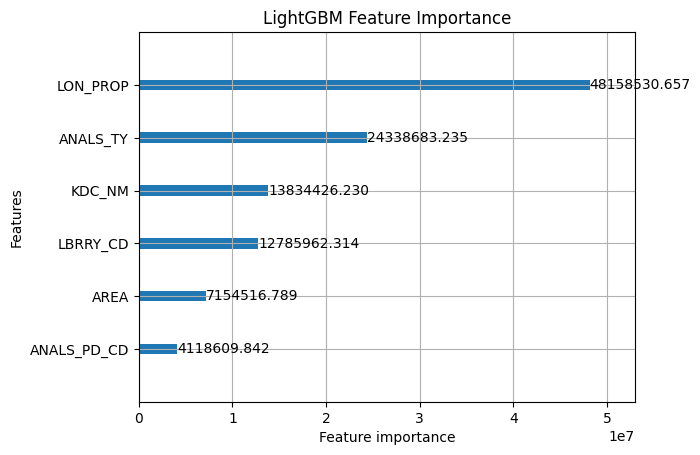

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import lightgbm as lgb
import matplotlib.pyplot as plt

## 1. 데이터 불러오기
load_path = '/content/drive/MyDrive/miniproject/data/ready.pkl'
data2 = pd.read_pickle(load_path)

# 제거
data2 = data2.drop(['RANK_CO'], axis=1)
data2 = data2[data2['LON_PROP'] != 0]

## 3. Feature & Target 분리
X2 = data2.drop(columns=['Y'])
y2 = data2['Y']

## 4. Train-Test 분리
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

## 5. LightGBM 학습 준비

# LightGBM은 category type을 int로 변환 필요
X_train2 = X_train2.copy()
X_valid2 = X_valid2.copy()

cat_features2 = X_train2.select_dtypes(include='category').columns

for col in cat_features2:
    X_train2[col] = X_train2[col].cat.codes
    X_valid2[col] = X_valid2[col].cat.codes

## 6. LightGBM 모델 학습
lgbm2 = lgb.LGBMClassifier(random_state=42)
lgbm2.fit(X_train2, y_train2)

## 7. 예측 및 평가
y_pred_lgbm2 = lgbm2.predict(X_valid2)
print("🔹LightGBM 평가")
print(classification_report(y_valid2, y_pred_lgbm2))

## 8. 피처 중요도 시각화
lgb.plot_importance(lgbm2, max_num_features=10, importance_type='gain')
plt.title("LightGBM Feature Importance")
plt.show()


### +) 해결을 위한 시도였던것...
1. 근본적인 문제
  - 사실상 정답지와 가까운 LON_PROP(대출율) 칼럼 이용
  - 연속형 변수가 거의 없고 범주형 변수가 대다수 -> 예측 모델을 만들기엔 어려움이 있지 않았나...
  - 추천시스템에서 벗어나기 위하려다 회생불가의 길로..  
=> 그래도 현재 상황에서 최대한 살려보고자 시도

2. 칼럼 수가 너무 적음
  - KDC_NM 칼럼 분할 시도  
  대분류 - 000,100,200,.../소분류 - 10,20, ... -> 이상값 (388..44, 7.8.1)으로 인한 처치 실패
  - 도서관별 인구 비율 데이터 추가 -> 모종의 계산 오류로 실패


3. 타임어택
  - 마감시간이 임박해서 두번째 lgbm모델을 완성본으로 선정


-> 이정도면 많이 나아졌지만 여전히.. 비정상적으로 정확도가 높음